In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from os import listdir
from os.path import isfile, join
from PIL import Image
import pickle

In [4]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5

def load_data():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_adj_band_{NUMBER_NODES}',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'./graphs_adj_band_{NUMBER_NODES}',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(32, 32),
        batch_size=32)
    return train_ds, val_ds

In [5]:
train_ds, val_ds = load_data()

Found 940 files belonging to 7 classes.
Using 752 files for training.
Found 940 files belonging to 7 classes.
Using 188 files for validation.


In [6]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(NUMBER_NODES, NUMBER_NODES, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Save test_Data to use it in compareResults (output_band, optimal_band, reverse-cuthill-mckee_band)
with open(os.path.join(os.path.abspath(''), 'class_names_band.pickle'), 'wb') as f:
    pickle.dump(class_names, f, pickle.HIGHEST_PROTOCOL)

In [7]:
model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(NUMBER_NODES, NUMBER_NODES, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=128,
)

Epoch 1/128
24/24 [==============================] - 3s 84ms/step - loss: 1.7574 - accuracy: 0.2939 - val_loss: 1.7653 - val_accuracy: 0.3404
Epoch 2/128
24/24 [==============================] - 1s 49ms/step - loss: 1.6508 - accuracy: 0.3511 - val_loss: 1.6974 - val_accuracy: 0.3457
Epoch 3/128
24/24 [==============================] - 1s 46ms/step - loss: 1.6050 - accuracy: 0.3590 - val_loss: 1.6288 - val_accuracy: 0.3457
Epoch 4/128
24/24 [==============================] - 1s 46ms/step - loss: 1.5351 - accuracy: 0.4136 - val_loss: 1.6423 - val_accuracy: 0.3723
Epoch 5/128
24/24 [==============================] - 1s 46ms/step - loss: 1.4459 - accuracy: 0.4455 - val_loss: 1.5642 - val_accuracy: 0.4202
Epoch 6/128
24/24 [==============================] - 1s 47ms/step - loss: 1.3914 - accuracy: 0.4441 - val_loss: 1.4678 - val_accuracy: 0.4521
Epoch 7/128
24/24 [==============================] - 1s 45ms/step - loss: 1.3105 - accuracy: 0.4880 - val_loss: 1.4520 - val_accuracy: 0.4309
Epoch 

In [8]:
model.save('CNN_dir_band_model')

INFO:tensorflow:Assets written to: CNN_dir_band_model\assets


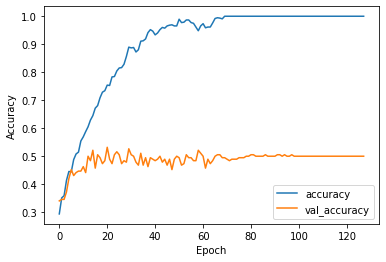

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

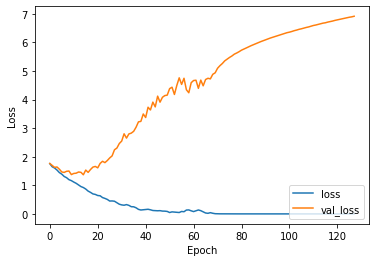

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [11]:
def get_bandwidth(Graph, nodelist):
    Graph = nx.Graph(Graph)
    if not Graph.edges:
        return 0
    L = nx.laplacian_matrix(Graph, nodelist=nodelist)
    x, y = np.nonzero(L)
    return (x-y).max()

def processDataToAdjImage(graphInput):
    adj = getGraph(graphInput)
    w, h = NUMBER_NODES, NUMBER_NODES
    data = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(adj)):
        for j in range(len(adj)):
            if adj[i, j] == 1:
                data[i, j] = np.array([255.0, 255.0, 255.0])
    # data /= 255.0
    img = Image.fromarray(data, 'RGB')
    resized = img.resize((32, 32), Image.NEAREST)
    image_input_np = np.array(resized)
    return image_input_np

def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

def getArray(strArray):
    arr = strArray.split('.')
    first = strArray[1]
    arr = [first, *arr[1 : -1]] # skip '[' and ']'
    arr = list(map(lambda x: int(x.strip()), arr))
    return arr

In [12]:
def load_test_data():
    NUMBER_NODES=7
    df = pd.read_csv(f'./test_adj2_graphs_{NUMBER_NODES}/teste_data2_{NUMBER_NODES}.csv')
    print(df.shape)

    featuresNumber = ((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 )
    features = df.iloc[ : , : featuresNumber ].values
    labels = df.iloc[ : , featuresNumber : featuresNumber + 1 ].values # get only bandwidth value
    return features, labels

In [13]:
test_features, test_labels = load_test_data()
print(test_features.shape)
print(test_labels.shape)

(104, 29)
(104, 21)
(104, 1)


In [30]:
list_pred = []
list_true = []

for x, true in zip(test_features, test_labels):
    get_graph_adj_image_arr = processDataToAdjImage(x)
    pred = model.predict(np.array([get_graph_adj_image_arr]))
    print("===")
    try:
        print(np.argmax(pred))
        print(class_names.index(str(int(true))))
    except ValueError:
        print(f"{true} not in class_names")
    
    print("as node list:")
    pred_bandwidth = class_names[np.argmax(pred)]
    print(pred_bandwidth)
    print(int(true))
    print("Bandwidth")
    list_pred.append(float(pred_bandwidth))
    list_true.append(float(true))

===
1
1
as node list:
1
1
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
1
1
as node list:
1
1
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
2
3
as node list:
2
3
Bandwidth
===
4
3
as node list:
4
3
Bandwidth
===
0
3
as node list:
0
3
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
3
2
as node list:
3
2
Bandwidth
===
5
2
as node list:
5
2
Bandwidth
===
1
2
as node list:
1
2
Bandwidth
===
2
3
as node list:
2
3
Bandwidth
===
5
3
as node list:
5
3
Bandwidth
===
2
2
as node list:
2
2
Bandwidth
===
2
3
as node list:
2
3
Bandwidth
===
4
3
as node list:
4
3
Bandwidth
===
1
3
as node list:
1
3
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
4
3
as node list:
4
3
Bandwidth
===
1
2
as node list:
1
2
Bandwidth
===
1
2
as node list:
1
2
Bandwidth
===
4
3
as node list:
4
3
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
0
3
as node list:
0
3
Bandwidth
===
0
3
as node list:
0
3
Bandwidth
===
3
3
as node list:
3
3
Bandwidth
===
3
3
as node list:
3
3
Ba

In [31]:
from sklearn.metrics import accuracy_score
list_pred = np.array(list_pred)
list_true = np.array(list_true)
accuracy_score(list_true, list_pred)

0.28846153846153844